# Data Analytics

## Unification of CSR Data

Note that this activity is also [Shopees Code League 2021's Data Analytics Hackathon Problem](https://www.kaggle.com/c/scl-2021-da) with a couple of revisions.

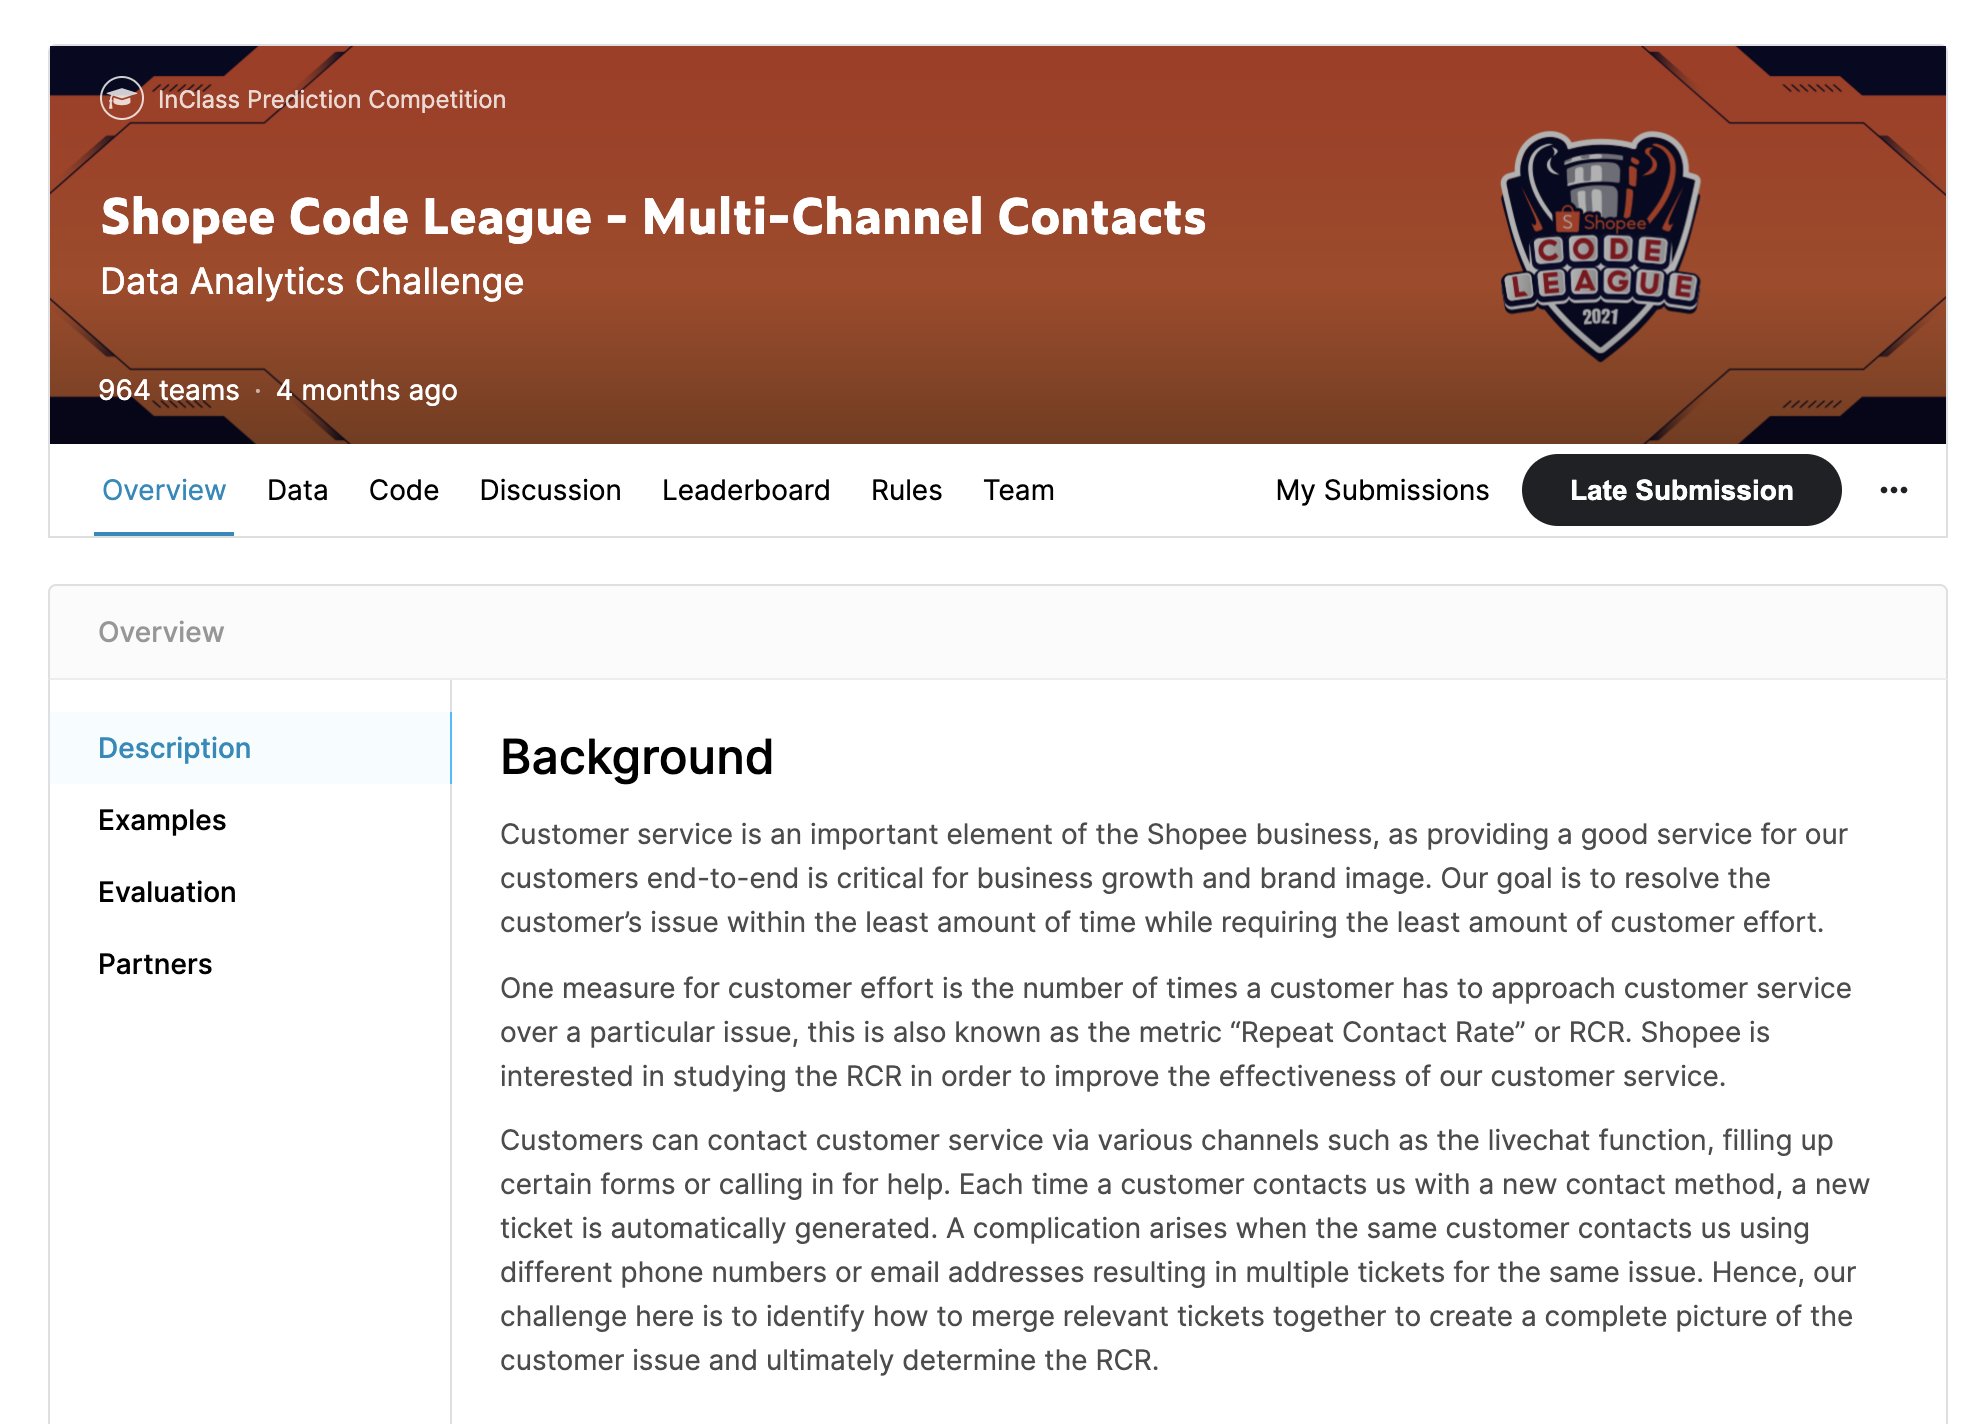

## Task
For each ticket, identify all contacts from each user if they have the same contact information.

For the purpose of this question, assume that all contacts from the same Phone Number / Email are the same user.

### Determine how many contacts each user has had across the various tickets.  This is analyzed for several reasons:
- Are we responding accordingly to the concerns of our customers?
- Are the resources distributed accordingly and maximized to address the needs of the customers?
- Are there gaps in our resources in maintaining the quality of work?

## Dataset 
The data fields of the Customer Service Data (Operations data) are as follows:
* ID               : Each Id represents the Ticket Id made to Customer Service.
* Email
* Phone         : All Phone Numbers are stored without the country code and the country code can be ignored.
* Contacts     : Contacts represent the number of times a user reached out to us in that particular ticket
* OrderId       : Each Order ID represents a transaction
* Status          : status of the ticket (Open, Pending, Resolved or Closed)
* Datetime
* CSR             : Person in charge of the ticket (used 9 different 3-char IDs)
* Address      : Region/Location (NCR Cities)
If a value is NA means that the system or agent has no record of that value.

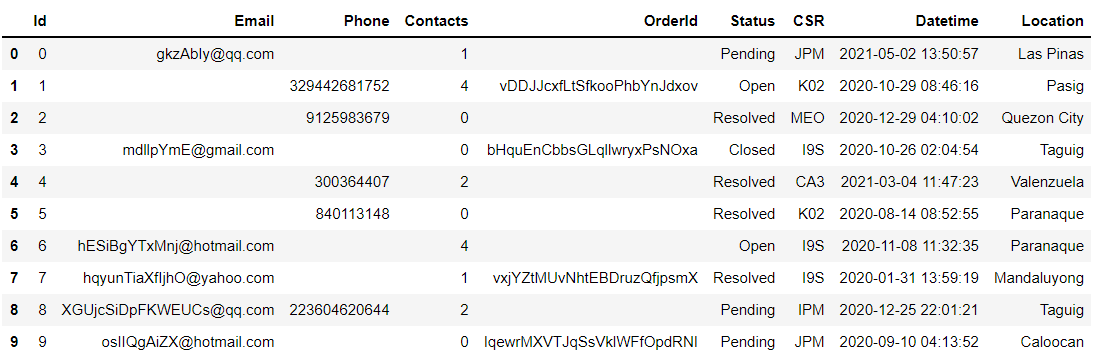

## Explanation
Each of these tickets are related either directly or indirectly through Email, Phone or Order ID, therefore each ticket belongs to the same user.

- Ticket A and B are linked through Order ID
- Tickets B and C are linked through Phone
- Tickets C and D are linked through Email
- Tickets A and D are indirectly linked through tickets A > B > C > D

In this example, this user has a total of 14 contacts. The ticket_trace/contact pair for this user would be 0-1-34567-78999, 14.

![e-KYC Diagram](sets.jpg)



## Expected Output

Two columns required:
- ticket_id
- ticket_trace/contact

### Format: (tickets in ascending order), (total contact)
|  | ticket_id | ticket_trace/contact |
| --- | --- | --- |
| 0 | 0-1-34567-78999 | 14 |
| 1 | 0-1-34567-78999 | 14 |
| 2 | 2-2456-4323-5343-6789 | 13 |

For each ticket, identify all other ticket_ids that belong to the same user, sorted in ascending order, as well as the total contacts the user had. If two tickets belong to the same user, the value for uid/contact for both tickets should be identical.

# Data Engineering

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('../data/transactions/crm_operations_data.csv')

# replace all ' ' strings with NaN value
df = df.replace(r'^\s*$', np.NaN, regex=True)
df.head(5)

,Id,Email,Phone,Contacts,OrderId,Status,CSR,Datetime,Location
0,0,gkzAbIy@qq.com,NaN,1,NaN,Pending,JPM,02/05/2021 13:50,Las Pinas
1,1,NaN,3.294430e+11,4,vDDJJcxfLtSfkooPhbYnJdxov,Open,K02,29/10/2020 8:46,Pasig
2,2,NaN,9.125984e+09,0,NaN,Resolved,MEO,29/12/2020 4:10,Quezon City
3,3,mdllpYmE@gmail.com,NaN,0,bHquEnCbbsGLqllwryxPsNOxa,Closed,I9S,26/10/2020 2:04,Taguig
4,4,NaN,3.003644e+08,2,NaN,Resolved,CA3,04/03/2021 11:47,Valenzuela


# CRS Unification

### Using sets -- Solution from [tongpollowat](https://www.kaggle.com/tongpollawat/short-fast-code-20sec-runtime-0-953)

In [2]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

#df = pd.read_csv('./csr_operations_data.csv')

# replace all ' ' strings with NaN value
df = df.replace(r'^\s*$', np.NaN, regex=True)
df

email_group = df.groupby('Email').Id.agg(lambda x: set(x))
phone_group = df.groupby('Phone').Id.agg(lambda x: set(x))
order_group = df.groupby('OrderId').Id.agg(lambda x: set(x))

d = {i: set() for i in df.Id}

for ids in email_group:
    for id in ids:
        d[id] |= set(ids)
for ids in phone_group:
    for id in ids:
        d[id] |= set(ids)
for ids in order_group:
    for id in ids:
        d[id] |= set(ids)

# Merge across groups again
for i in tqdm(range(3)):
    for id, ids in d.items():
        for id_ in list(ids):
            d[id] |= d[id_]
            
            
id_to_contact = df.set_index('Id').Contacts.to_dict()

def get_sum_contact(ids_set):
    return sum([id_to_contact[id] for id in ids_set])

df['set'] = df.Id.apply(lambda x: d[x])
df['trace'] = df.set.apply(lambda x: '-'.join(map(str, sorted(list(x)))))
df['n_con'] = df.set.apply(lambda x: str(get_sum_contact(x)))
df['out'] = df.trace + ', ' + df.n_con
out = df[['Id', 'out']]
out.columns = ['ticket_id', 'ticket_trace/contact']
out

out.to_csv('out.csv', index=False)

## Analysis

In [3]:
out_analysis = pd.DataFrame()
out_analysis['ticket_id'] = df.trace
out_analysis['ticket_trace/contact'] = df.n_con

out_analysis['ticket_trace/ids'] = out_analysis.ticket_id.str.count("-")+1
#out_analysis

In [4]:
out_analysis.head(5)

,ticket_id,ticket_trace/contact,ticket_trace/ids
0,0,1,1
1,1-2458-98519-115061-140081-165605-476346,12,7
2,2-159312-322639-348955,4,4
3,3,0,1
4,4,2,1


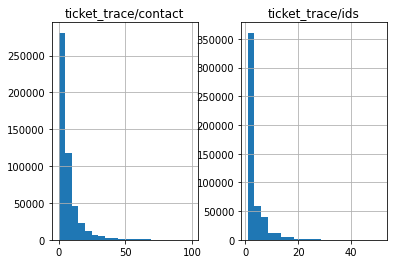

In [5]:
out_analysis["ticket_trace/contact"] = pd.to_numeric(out_analysis["ticket_trace/contact"])
hist = out_analysis.hist(bins=20)

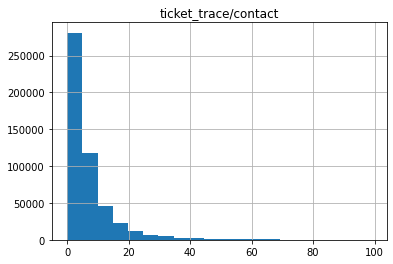

In [6]:
out_analysis["ticket_trace/contact"] = pd.to_numeric(out_analysis["ticket_trace/contact"])
hist = out_analysis.hist(column = ['ticket_trace/contact'],bins=20)

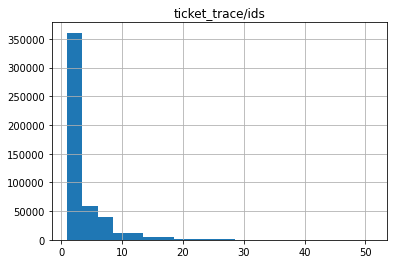

In [7]:
hist = out_analysis.hist(column = ['ticket_trace/ids'],bins=20)